In [ ]:
import matplotlib.pyplot as plt
from shapely import Polygon
import geopandas as gpd
from src.s2_grid import split_polygon
from src.aggregation import aggregate_features

In [3]:
imgs = gpd.read_file('data/S2_GRID.geojson')
demo = gpd.read_file('data/DEMOGRAPHY.geojson')

In [5]:
temp = gpd.read_file('data/PARKS.geojson')
demo.head()

region_id  population                                           geometry
0      21993          39  POLYGON ((-740564.951 -1051146.02, -740610.951...
1      13498        2080  POLYGON ((-736307.954 -1040403.019, -736520.95...
2      13139        3206  POLYGON ((-743136.952 -1044268.02, -743085.953...
3      13337        1523  POLYGON ((-746423.943 -1042359.22, -746445.684...
4       7092         278  POLYGON ((-730015.05 -1054704.887, -730021.951...

In [21]:
img1 = imgs.loc[0].geometry
geoms = split_polygon(img1, number_of_pixels_on_side=15, thresh=0.9)
len(geoms)

225

In [19]:
import geopandas as gpd
from shapely.ops import unary_union

def fix_geometry(geom):
    if not geom.is_valid:
        geom = geom.buffer(0)
    return geom

def aggregate_parks(tile, gdf):
    parks_area = 0
    tile = fix_geometry(tile)
    sindex = gdf.sindex
    possible_matches_index = list(sindex.intersection(tile.bounds))
    possible_matches = gdf.iloc[possible_matches_index]
    for _, row in possible_matches.iterrows():
        if tile.intersects(row.geometry):
            parks_area += tile.intersection(row.geometry).area
    return tile, parks_area / tile.area

def aggregate_noise(tile, gdf):
    total_noise = 0
    total_area = 0
    tile = fix_geometry(tile)
    sindex = gdf.sindex
    possible_matches_index = list(sindex.intersection(tile.bounds))
    possible_matches = gdf.iloc[possible_matches_index]
    for _, row in possible_matches.iterrows():
        if tile.intersects(row.geometry):
            intersection_area = tile.intersection(row.geometry).area
            total_noise += intersection_area * row.DB_HI
            total_area += intersection_area
    avg_noise = total_noise / total_area if total_area != 0 else 0
    avg_noise = round(avg_noise / 5) * 5
    return tile, avg_noise

def aggregate_population(tile, gdf):
    population = 0
    tile = fix_geometry(tile)
    sindex = gdf.sindex
    possible_matches_index = list(sindex.intersection(tile.bounds))
    possible_matches = gdf.iloc[possible_matches_index]
    for _, row in possible_matches.iterrows():
        if tile.intersects(row.geometry):
            area_ratio = (tile.intersection(row.geometry).area / tile.area)
            population += area_ratio * row.population
    return tile, population

def aggregate_features(tile):
    parks_gdf = gpd.read_file('data/PARKS.geojson')
    noise_gdf = gpd.read_file('data/NOISE_SPLIT.geojson')
    demography_gdf = gpd.read_file('data/DEMOGRAPHY.geojson')
    tiles = []
    parks_areas = []
    avg_noises = []
    populations = []

    try:
        tile = tile.geometry
        _, avg_noise = aggregate_noise(tile, noise_gdf)
        _, parks_area = aggregate_parks(tile, parks_gdf)
        _, population = aggregate_population(tile, demography_gdf)
        tiles.append(tile)
        avg_noises.append(avg_noise)
        parks_areas.append(parks_area)
        populations.append(population)
    except Exception as e:
        print(f"Error processing tile: {e}")
    
    output_dict = {
        'avg_noise': avg_noises,
        'parks_area': parks_areas,
        'population': populations,
        'geometry': tiles
    }
    
    output_gdf = gpd.GeoDataFrame(output_dict)
    output_gdf.set_geometry('geometry', inplace=True)
    output_gdf.set_crs(epsg=5514, inplace=True)
    print('Features aggregated successfully')
    return output_gdf

In [22]:
for _, img in imgs.head(1).iterrows():
    geoms = split_polygon(img.geometry, 
                          number_of_pixels_on_side = 15, 
                          thresh = 0.9)
    for geom in geoms[:5]:
        aggregate_features(geom)
        

KeyboardInterrupt: 

In [8]:
temp = []
for _, img in imgs.iterrows():
    geoms = split_polygon(img.geometry, number_of_pixels_on_side=15, thresh=0.9)
    # for geom in geoms:
    #     aggregate_features(geom, demo, temp)
    #     break
    temp.append(geoms)

temp

[[<POLYGON ((-746187.429 -1058799.6, -746285.838 -1058799.6, -746285.838 -1058...>,
  <POLYGON ((-746285.838 -1058799.6, -746384.248 -1058799.6, -746384.248 -1058...>,
  <POLYGON ((-746384.248 -1058799.6, -746482.657 -1058799.6, -746482.657 -1058...>,
  <POLYGON ((-746482.657 -1058799.6, -746581.066 -1058799.6, -746581.066 -1058...>,
  <POLYGON ((-746581.066 -1058799.6, -746679.475 -1058799.6, -746679.475 -1058...>,
  <POLYGON ((-746679.475 -1058799.6, -746777.885 -1058799.6, -746777.885 -1058...>,
  <POLYGON ((-746777.885 -1058799.6, -746876.294 -1058799.6, -746876.294 -1058...>,
  <POLYGON ((-746876.294 -1058799.6, -746974.703 -1058799.6, -746974.703 -1058...>,
  <POLYGON ((-746974.703 -1058799.6, -747073.112 -1058799.6, -747073.112 -1058...>,
  <POLYGON ((-747073.112 -1058799.6, -747171.522 -1058799.6, -747171.522 -1058...>,
  <POLYGON ((-747171.522 -1058799.6, -747269.931 -1058799.6, -747269.931 -1058...>,
  <POLYGON ((-747269.931 -1058799.6, -747368.34 -1058799.6, -747368.34 -1058

In [9]:
len(temp)

262

In [5]:
aggregate_features()

Features aggregated successfully


In [12]:
gpd.read_file('data/OUTPUT_DATA.geojson').head()

avg_noise  parks_area  population  \
0         50    0.115111   26.165506   
1         55    0.093299  121.297592   
2         30    0.000000  157.668972   
3         25    0.000000   16.482080   
4         45    0.000000  130.915898   

                                            geometry  
0  POLYGON ((-746187.429 -1058799.6, -747663.568 ...  
1  POLYGON ((-747663.568 -1058799.6, -749139.707 ...  
2  POLYGON ((-749139.707 -1058799.6, -750615.845 ...  
3  POLYGON ((-750615.845 -1058799.6, -752091.984 ...  
4  POLYGON ((-752091.984 -1055715.058, -750615.84...

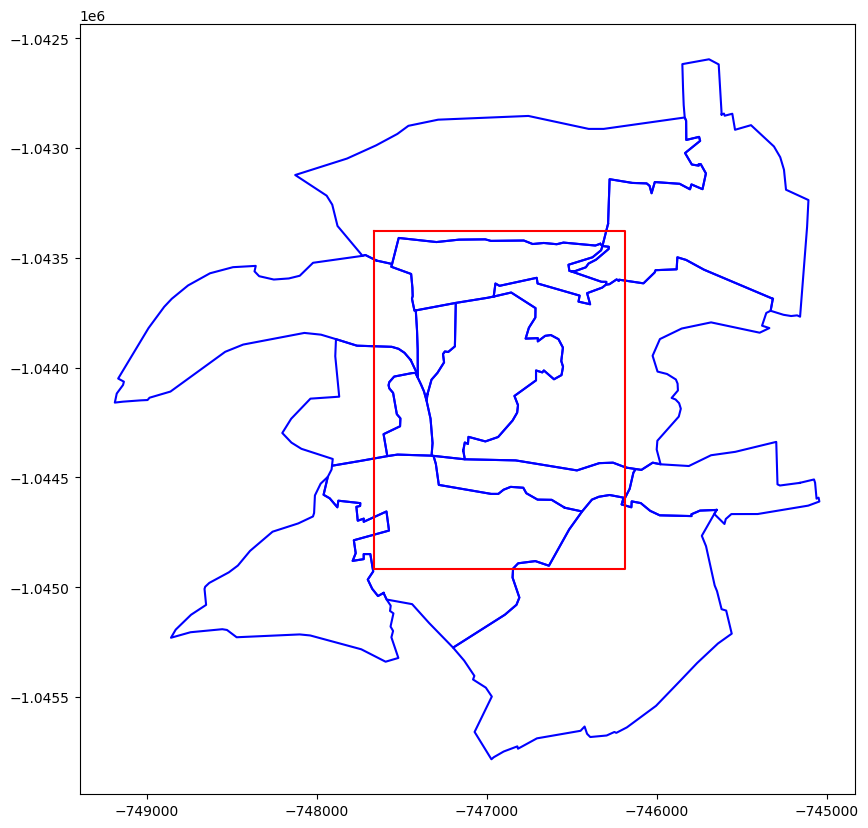

In [85]:
first_img = imgs.geometry.values[150]
demo_list = demo.geometry.values
polygons = [poly for poly in demo_list if first_img.intersection(poly)]
fig, ax = plt.subplots(figsize=(10, 10))
for geom in polygons:
    if isinstance(geom, Polygon):
        x, y = geom.exterior.xy
        ax.plot(x, y, color = 'blue')
ax.plot(*first_img.exterior.xy, color='red')

plt.show()